Nama: Syalista Galuh Nadira

NIM: 2702346361

In [ ]:
from google.colab import drive
import os

drive.mount('/content/drive')

!unzip -q "/content/drive/MyDrive/B_2.zip"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
replace B_23/siirt 830.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from skimage.metrics import structural_similarity as ssim

# Exploratory Data Analysis (EDA)

In [ ]:
image_folder = 'B_23'

image_files = [f for f in os.listdir(image_folder)]

num_images = len(image_files)
print(f"Total gambar: {len(image_files)}")

aspect_ratios = {}
image_formats = {}

for image_file in image_files:
  img_path = os.path.join(image_folder, image_file)
  with Image.open(img_path) as img:
    width, height = img.size
    aspect_ratio = f"{width}:{height}"
    aspect_ratios[aspect_ratio] = aspect_ratios.get(aspect_ratio, 0) + 1
    image_formats[img.format] = image_formats.get(img.format, 0) + 1

print("\nAspect ratio:") # untuk tau apakah aspect ratio semua gambar sama
for ratio, count in aspect_ratios.items():
    print(f"{ratio}: {count}")

print("\nFormat data:") # untuk tau apakah format semua gambar sama
for fmt, count in image_formats.items():
    print(f"{fmt}: {count}")

image_sizes = {}
for img in image_files:
    img_path = os.path.join(image_folder, img)
    with Image.open(img_path) as img:
        size = img.size  # (width, height)
        if size in image_sizes:
            image_sizes[size] += 1
        else:
            image_sizes[size] = 1

print("\nUkuran gambar:") # untuk tau apakah dimensi semua gambar sama
for size, count in image_sizes.items():
    print(f"{size}: {count}")

corrupt_images = []
for img in image_files:
    img_path = os.path.join(image_folder, img)
    try:
        with Image.open(img_path) as img:
            img.verify()
    except Exception as e:
        corrupt_images.append(img)

print(f"\nGambar corrupt: {len(corrupt_images)}")
if corrupt_images:
    print(corrupt_images)

Total gambar: 1074

Aspect ratio:
600:600: 1074

Format data:
JPEG: 1074

Ukuran gambar:
(600, 600): 1074

Gambar corrupt: 0


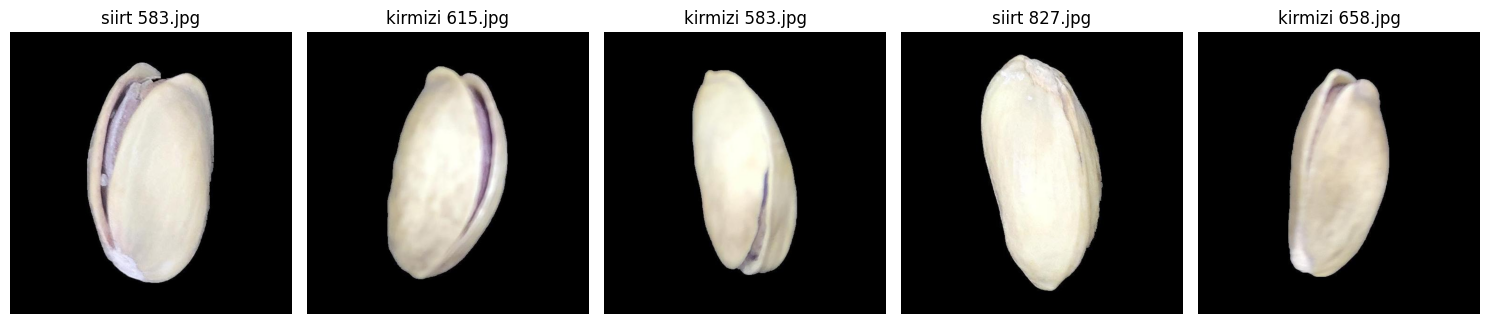

In [ ]:
# Contoh gambar
sample_img = image_files[:5]
fig, axes = plt.subplots(1, len(sample_img), figsize=(15, 5))

for ax, file in zip(axes, sample_img):
    img = Image.open(os.path.join(image_folder, file))
    ax.imshow(img)
    ax.set_title(file)
    ax.axis('off')

plt.tight_layout()
plt.show()

---

# Data Preprocessing

In [ ]:
def get_image_paths(folder):
    return [os.path.join(folder, fname) for fname in os.listdir(folder)]

image_folder = 'B_23'
image_paths = get_image_paths(image_folder)

# Split
train_paths, temp_paths = train_test_split(image_paths, test_size=0.2, random_state=42)
val_paths, test_paths = train_test_split(temp_paths, test_size=0.5, random_state=42)

# Resize dan normalisasi
def preprocess_images(paths, size=(100, 100)):
    images = []
    for path in paths:
        with Image.open(path) as img:
            img = img.convert('RGB')
            img = img.resize(size)
            img_array = np.asarray(img) / 255.0
            images.append(img_array)
    return np.array(images)

# Gambar clean
x_train_clean = preprocess_images(train_paths)
x_val_clean = preprocess_images(val_paths)
x_test_clean = preprocess_images(test_paths)

print("x_train_clean:", x_train_clean.shape)
print("x_test_clean:", x_test_clean.shape)
print("x_val_clean:", x_val_clean.shape)

x_train_clean: (859, 100, 100, 3)
x_test_clean: (108, 100, 100, 3)
x_val_clean: (107, 100, 100, 3)


In [ ]:
# Tambah Gaussian noise
def add_gaussian_noise(images, mean=0.0, std=0.1):
    noise = np.random.normal(mean, std, images.shape)
    noisy = images + noise
    return np.clip(noisy, 0., 1.)

# Gambar noisy
x_train_noisy = add_gaussian_noise(x_train_clean)
x_val_noisy = add_gaussian_noise(x_val_clean)
x_test_noisy = add_gaussian_noise(x_test_clean)

print("x_train_noisy:", x_train_noisy.shape)
print("x_test_noisy:", x_test_noisy.shape)
print("x_val_noisy:", x_val_noisy.shape)

x_train_noisy: (859, 100, 100, 3)
x_test_noisy: (108, 100, 100, 3)
x_val_noisy: (107, 100, 100, 3)


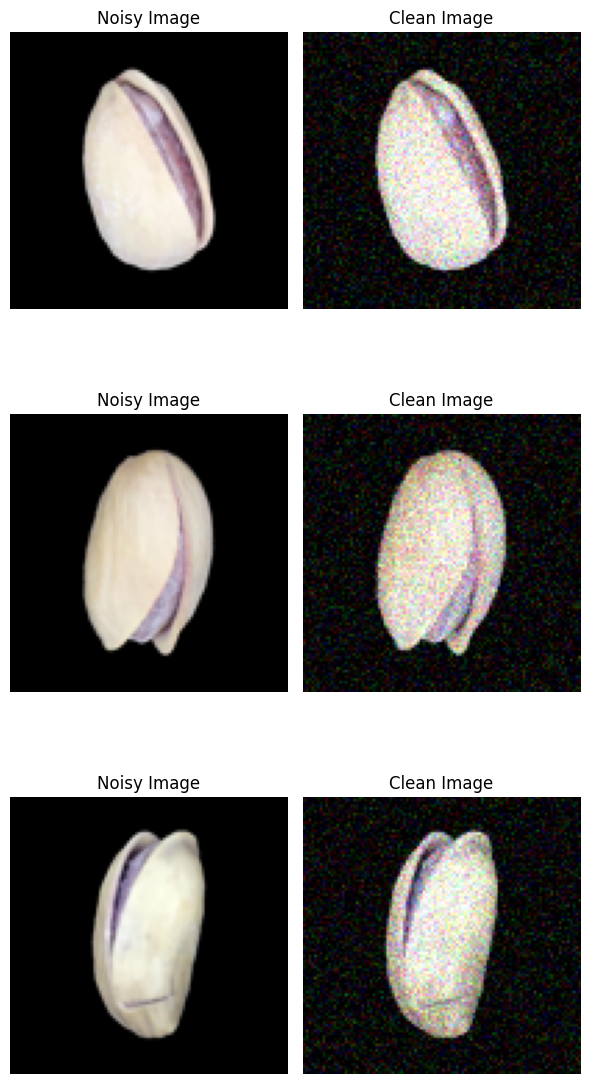

In [ ]:
# Perbandingan gambar noisy dan clean
n = 3
plt.figure(figsize=(6, 4 * n))

for i in range(n):
    # Noisy image (input)
    plt.subplot(n, 2, 2*i + 1)
    plt.imshow(x_train_clean[i])
    plt.title("Noisy Image")
    plt.axis('off')

    # Clean image (target)
    plt.subplot(n, 2, 2*i + 2)
    plt.imshow(x_train_noisy[i])
    plt.title("Clean Image")
    plt.axis('off')

plt.tight_layout()
plt.show()

---

# Baseline Autoencoder Model

In [ ]:
inputs = Input(shape=(100, 100, 3))

In [ ]:
# Encoder
x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)

# Decoder
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
output_layer = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

base_autoenc = Model(inputs = inputs, outputs = output_layer)
base_autoenc.compile(optimizer=Adam(), loss='mse')

base_autoenc.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_66 (Conv2D)              │ (None, 100, 100, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_67 (Conv2D)              │ (None, 50, 50, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_68 (Conv2D)              │ (None, 25, 25, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_24 (UpSampling2D) │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_69 (Conv2D)              │ (None, 50, 50, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_25 (UpSampling2D) │ (None, 100, 100, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_70 (Conv2D)              │ (None, 100, 100, 3)    │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,651 (295.51 KB)

 Trainable params: 75,651 (295.51 KB)

 Non-trainable params: 0 (0.00 B)

---

# Modified Autoencoder Model

Modifikasi: Tambahan 1 layer Conv2D sebelum upsampling terakhir untuk memperkaya representasi fitur, sehingga decoder dapat merekonstruksi detail spasial dengan lebih baik saat melakukan upsampling berikutnya.

In [ ]:
# Encoder
x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)

# Decoder
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x) # modifikasi: layer tambahan
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

mod_autoenc = Model(inputs, decoded)
mod_autoenc.compile(optimizer=Adam(), loss='mse')
mod_autoenc.summary()

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_71 (Conv2D)              │ (None, 100, 100, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_72 (Conv2D)              │ (None, 50, 50, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_73 (Conv2D)              │ (None, 25, 25, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_26 (UpSampling2D) │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_74 (Conv2D)              │ (None, 50, 50, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_75 (Conv2D)              │ (None, 50, 50, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_27 (UpSampling2D) │ (None, 100, 100, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_76 (Conv2D)              │ (None, 100, 100, 3)    │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 112,579 (439.76 KB)

 Trainable params: 112,579 (439.76 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train baseline model
baseline_history = base_autoenc.fit(
    x_train_noisy, x_train_clean,
    validation_data=(x_val_noisy, x_val_clean),
    epochs=25,
    batch_size=32,
    shuffle=True,
)

Epoch 1/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 93ms/step - loss: 0.1197 - val_loss: 0.0047
Epoch 2/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0042 - val_loss: 0.0030
Epoch 3/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0028 - val_loss: 0.0025
Epoch 4/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0024 - val_loss: 0.0021
Epoch 5/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0022 - val_loss: 0.0020
Epoch 6/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0019 - val_loss: 0.0017
Epoch 7/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 8/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0015 - val_loss: 0.0017
Epoch 9/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0020 - val_loss: 0.0017
Epoch 10/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 11/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 12/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0

In [ ]:
# Train modified model
mod_history = mod_autoenc.fit(
    x_train_noisy, x_train_clean,
    validation_data=(x_val_noisy, x_val_clean),
    epochs=25,
    batch_size=32,
    shuffle=True,
    callbacks = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
)

Epoch 1/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - loss: 0.1131 - val_loss: 0.0038
Epoch 2/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0035 - val_loss: 0.0031
Epoch 3/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0030 - val_loss: 0.0028
Epoch 4/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0026 - val_loss: 0.0025
Epoch 5/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0024 - val_loss: 0.0020
Epoch 6/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0019 - val_loss: 0.0017
Epoch 7/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 8/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 9/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 10/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 11/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 12/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0

Model Evaluation

In [ ]:
def compute_ssim(model, x_noisy, x_clean):
    prediction = model.predict(x_noisy)
    scores = []
    for i in range(len(x_clean)):
        pred_gray = np.mean(prediction[i], axis=-1)     # convert to grayscale
        target_gray = np.mean(x_clean[i], axis=-1)  # convert to grayscale
        score = ssim(pred_gray, target_gray, data_range=1.0)
        scores.append(score)
    return np.mean(scores)

base_ssim = compute_ssim(base_autoenc, x_test_noisy, x_test_clean)
mod_ssim = compute_ssim(mod_autoenc, x_test_noisy, x_test_clean)

print("SSIM Baseline Autoencoder:", base_ssim)
print("SSIM Modified Autoencoder:", mod_ssim)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step


1/4 ━━━━━━━━━━━━━━━━━━━━ 1s 361ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step
SSIM Baseline Autoencoder: 0.9526054879847504
SSIM Modified Autoencoder: 0.9569583373085337


Penambahan satu layer Conv2D di bagian decoder sebelum upsampling terakhir meningkatkan kemampuan model dalam merekonstruksi detail spasial, sehingga SSIM naik dari 0.952 menjadi 0.956.

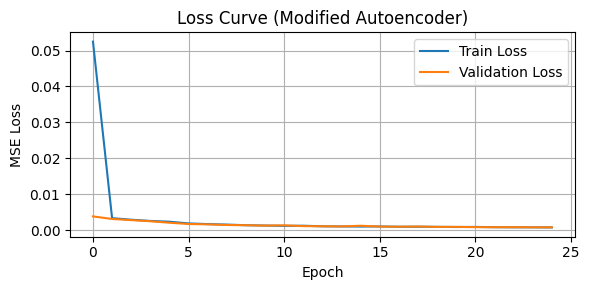

In [ ]:
# Plot loss modified model
plt.figure(figsize=(6, 3))
plt.plot(mod_history.history['loss'], label='Train Loss')
plt.plot(mod_history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve (Modified Autoencoder)')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Dari grafik:

* Train loss turun drastis di awal, kemudian sejajar dengan validation loss
* Validation loss stabil & rendah sepanjang epoch -> model tidak overfitting
* Gap kecil antar keduanya -> model generalize dengan baik

Kesimpulan:
Model modifikasi cepat konvergen dan performa stabil, cocok untuk tugas image denoising ini.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


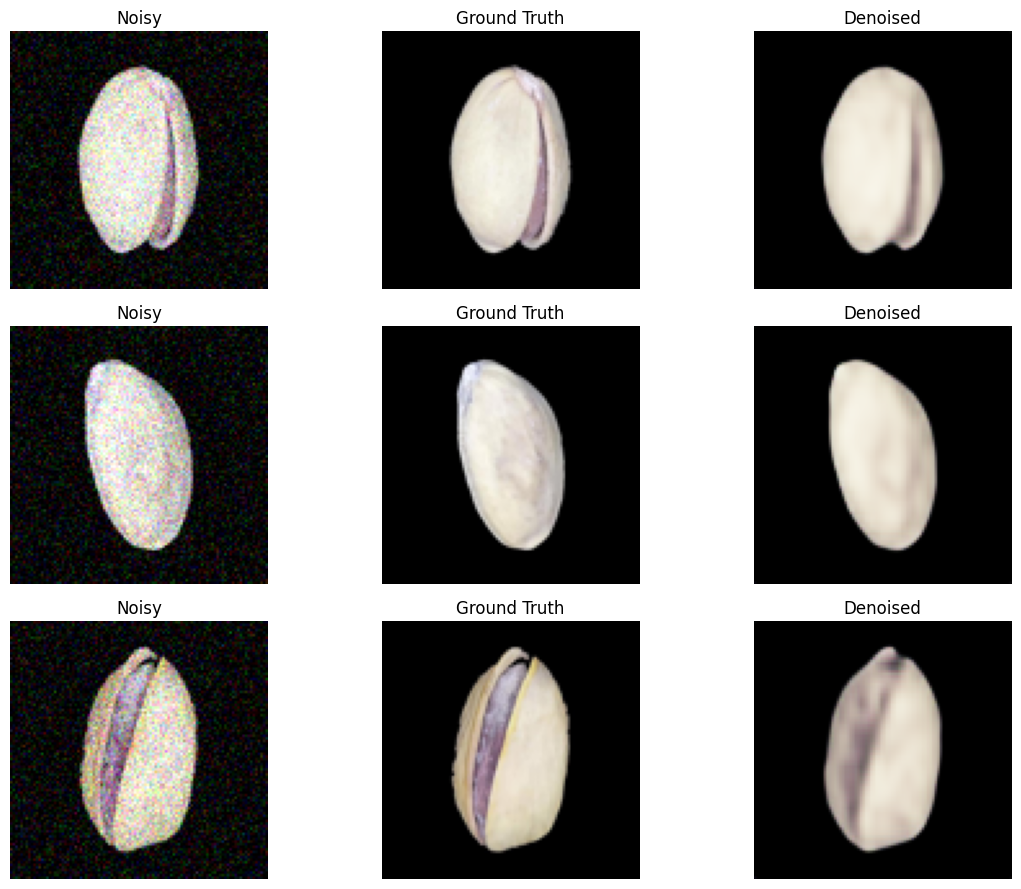

In [ ]:
indices = np.random.choice(len(x_test_noisy), 3, replace=False)

predicted = mod_autoenc.predict(x_test_noisy[indices])

plt.figure(figsize=(12, 3 * 3))

for i, idx in enumerate(indices):
    # Noisy image
    plt.subplot(3, 3, i * 3 + 1)
    plt.imshow(x_test_noisy[idx])
    plt.title("Noisy")
    plt.axis('off')

    # Ground truth
    plt.subplot(3, 3, i * 3 + 2)
    plt.imshow(x_test_clean[idx])
    plt.title("Ground Truth")
    plt.axis('off')

    # Denoised prediction
    plt.subplot(3, 3, i * 3 + 3)
    plt.imshow(predicted[i])
    plt.title("Denoised")
    plt.axis('off')

plt.tight_layout()
plt.show()

# Presentation video
Link video: https://drive.google.com/drive/folders/1MyWSBI5JUqLo_HTm5Bil-h7u5RLIHnJt?usp=sharing